In [1]:
from IPython.display import Image
import itertools

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

import autograd.numpy as np
from autograd.numpy import trace
from autograd.numpy.linalg import det
from autograd.numpy.linalg import inv
from autograd.scipy.stats import norm
from autograd.scipy.special import gamma as gammaFn
from autograd.scipy.special import polygamma

from autograd import grad

%matplotlib inline

Utility functions...

In [2]:
def besselFn_helper(x, v=5, M=10):
    s = 0.
    for m in xrange(M):
        s += (1./(gammaFn(m+1)*gammaFn(m+v+1))) * (x/2.)**(2*m+v)
    return s

def besselFn(v, x):
    return np.pi/2. * (besselFn_helper(x,-v) - besselFn_helper(x,v))/np.sin(np.pi*v)

# Stein Variational Gradient Descent
### by Qiang Liu, Dilin Wang (https://arxiv.org/abs/1608.04471)

Particles explore the posterior according to the following iterative algorithm
$$ \theta_{i}^{l+1} \leftarrow \theta_{i}^{l} + \epsilon \boldsymbol{\hat \phi}(\theta_{i}^{l}) \text{  where  } \boldsymbol{\hat \phi}(\theta_{i}^{l}) = \frac{1}{n} \sum_{j=1}^{n} k(\theta_{j}^{l}, \theta) \nabla_{\theta_{j}^{l}} \log p(\theta_{j}^{l}) + \nabla_{\theta_{j}^{l}} k(\theta_{j}^{l}, \theta)$$
where $k$ is a valid kernel and $\epsilon$ is a step-size.  The operator $\boldsymbol{\hat \phi}(\theta_{i}^{l})$ is implemented below:

In [3]:
def steinOp(x, idx, dLogModel, params, kernel, kernelParams=None):
    returnVal = 0.
    n = len(x)
    for j in xrange(n):
        returnVal += kernel['f'](x[j], x[idx]) * dLogModel(x[j],params) + kernel['df'](x[j], x[idx])
    return 1./n * returnVal

### Kernel Functions
The choice of kernel is straightforward for $\mathbb{R}$; the RBF and Matern work well.  When the particles are restriced to some bounded domain, the choice becomes less clear.  There are several options:

1) Transform to $\mathbb{R}$ and perform regular SVGD.

2) Contrive a kernel $k'(x_{1},x_{2}) = f(x_{1})k(x_{1},x_{2})f(x_{2})$ where $f$ is some function that is zero on the boundary and $k$ is regular pd kernel with no boundary considerations.

3) Consider the Sobolev space with appropriate boundaries and use the corresponding kernel.

4) Use a Fisher or related kernel

5) Use a heat kernel on the appropriate manifold.

We'll test the options above for some common distributions. 

### Kernels for $\mathbb{R}^{d}$

In [4]:
# Radial Basis Function (Heat Kernel)
def rbf(x1, x2, params={'lengthScale': 1}):
    return np.exp((-.5/params['lengthScale']) * np.sum((x1-x2)**2))

# Matern
def matern(x1, x2, params={'v': 1 ,'l': 6.}):
    # np.abs seems to be problematic w/ autograd, hacking
    if x1 > x2: d = x1 - x2
    else: d = x2 - x1
    temp = ((np.sqrt(2*params['v'])/params['l']) * np.sum(d))
    return (2**(1-params['v'])/gammaFn(params['v'])) * temp**params['v'] * besselFn(params['v'], temp) 

### Kernels for $\mathbb{R}^{d}_{>0}$

In [5]:
# Diffusion Kernel for Gamma r.v.'s via Parametrix Expansion
# Dropped \Psi terms following (Lafferty & Lebanon, 2005)
def gamma_diffusion(x1, x2, params={'t': .01}):
    try: n = len(x1) 
    except: n = 1
    squ_geo = np.sum((polygamma(1,x1)-polygamma(1,x2))**2) 
    return (4*np.pi*params['t'])**(-n/2.) * np.exp((-.25/params['t']) * squ_geo)

### Kernels for $\mathbb{R} \in [0, 1]$

In [69]:
def bernoulli_prob_prod(x1, x2, params={'p':.85}):
    return (x1*x2)**params['p'] + (1-x1)**params['p'] * (1-x2)**params['p']

# First order Sovolex on [0,1]
def unit_sobolev(x1, x2):
    return 2*(np.minimum(x1,x2) - x1*x2)

def bernoulli_kld(p1, p2):
    return p1 * np.log(p1/p2) + (1-p1) * np.log((1-p1)/(1-p2))

def beta_score(x, params):
    v1 = np.log(x) - polygamma(0,params['alpha']) + polygamma(0,params['alpha']+params['beta'])
    v2 = np.log(1-x) - polygamma(0,params['beta']) + polygamma(0,params['alpha']+params['beta'])
    return np.array([[v1, v2]])

def beta_fisher(x1, x2, params={'alpha':1.,'beta':1.}):
    score1 = beta_score(x1, params)
    score2 = beta_score(x2, params)
    temp = polygamma(1,params['alpha']+params['beta'])
    fisher_info_mat = np.array([[polygamma(1,params['alpha']) - temp, -temp],[-temp, polygamma(1,params['beta']) - temp]])
    return np.dot(np.dot(score1, inv(fisher_info_mat)), score2.T)[0,0]

## Models

### Gaussian Mixture Model

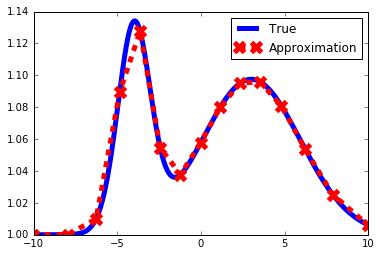

In [7]:
# Model
def gaussPdf(x, params):
    return (1./np.sqrt(2*np.pi*params['sigma']**2)) * np.exp((-.5/params['sigma']**2) * np.sum((x-params['mu'])**2))

def logGaussMixPDF(x, params):
    return params['pi'][0] * gaussPdf(x, {'mu':params['mu'][0], 'sigma':params['sigma'][0]}) \
            + params['pi'][1] * gaussPdf(x, {'mu':params['mu'][1], 'sigma':params['sigma'][1]})
                                         
logModel = logGaussMixPDF
dLogModel = grad(logModel)
params = {
    'mu': [-4,3],
    'sigma': [1, 3],
    'pi': [.3, .7]
}

# kernel
kernel = {'f': rbf}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.normal

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0())
    
maxEpochs = 100
lr = 2.
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]    
x_true = np.linspace(-10, 10, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.xlim([-10,10])
plt.legend()

### Gamma Mixture Model

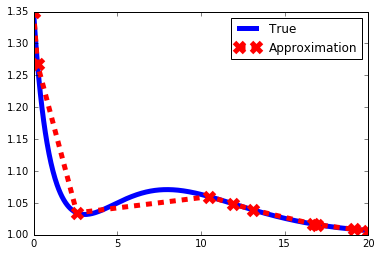

In [8]:
# Model
def gammaPdf(x, params):
    return x**(params['shape']-1)/(gammaFn(params['shape'])*params['scale']**params['shape']) * np.exp(-x/params['scale'])

def logGammaMixPDF(x, params):
    return params['pi'][0] * gammaPdf(x, {'shape':params['shape'][0], 'scale':params['scale'][0]}) \
            + params['pi'][1] * gammaPdf(x, {'shape':params['shape'][1], 'scale':params['scale'][1]})
                                         
logModel = logGammaMixPDF
dLogModel = grad(logModel)
params = {
    'shape': [1, 5],
    'scale': [1, 2],
    'pi': [.3, .7]
}

# kernel
kernel = {'f': gamma_diffusion}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.gamma

### generate samples
n = 15
x = []
for sampleIdx in xrange(n):
    x.append(q0(shape=7))

maxEpochs = 100
lr = 2
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)
        # check boundary condition, reflect if <= 0
        if x[idx] <=0: x[idx] = np.abs(x[idx])

x.sort()
probs = [np.exp(logModel(z, params)) for z in x]  

x_true = np.linspace(0, 20, 1000)
probs_true = [np.exp(logModel(z, params)) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.xlim([0,20])
plt.legend()

### Reference Prior

SVGD can also be used to compute reference priors.  See [(Nalisnick & Smyth, 2017)](https://arxiv.org/abs/1704.01168).  

/Users/enalisnick/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  app.launch_new_instance()


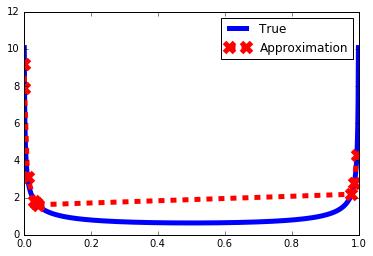

In [70]:
# Model
def bernoulli_Jeffreys(x):
    return 1./(np.pi * np.sqrt(x*(1-x)))

def neg_entropy(x, params):
    return -(-x*np.log(x) + -(1-x)*np.log(1-x))

                                         
logModel = neg_entropy
dLogModel = grad(logModel)
params = {
}

# kernel
kernel = {'f': bernoulli_prob_prod}
kernel['df'] = grad(kernel['f'])

# initial distribution
q0 = np.random.uniform

### generate samples
n = 10
x = []
for sampleIdx in xrange(n):
    x.append(q0())

maxEpochs = 100
lr = .01
for epochIdx in xrange(maxEpochs):
    for idx in xrange(n):
        x[idx] += lr * steinOp(x, idx, dLogModel, params, kernel)
        # check boundary condition
        if x[idx]<=0: x[idx] = np.abs(x[idx])
        if x[idx]>=1: x[idx] = 1-(x[idx]-1)

x.sort()
probs = [bernoulli_Jeffreys(z) for z in x]  

x_true = np.linspace(0, 1, 1000)
probs_true = [bernoulli_Jeffreys(z) for z in x_true]

plt.plot(x_true, probs_true, 'b-', linewidth=5, label="True")
plt.plot(x, probs, 'rx--', markersize=10, mew=5, linewidth=5, label="Approximation")
plt.xlim([0,1])
plt.legend()




## Appendix

### Parametrix Expansion
For most geometries, there is no closed-form solution for the heat kernel.  However, short-time behavior follows the *parametrix expansion* $$ P^{(m)}_{t}(x,y) = (4 \pi t)^{-n/2} exp\{ \frac{- d^{2}(x,y)}{4t} \} (\Psi_{0}(x,y) + \Psi_{1}(x,y) t  + \ldots + \Psi_{m}(x,y) t^{m} )$$ where the $\Psi$'s are defined recursively as $$\Psi_{0} = (\frac{\sqrt{det g}}{d^{n-1}})^{-1/2} \text{ , } \Psi_{k} = r^{-k}\Psi_{0} \int_{0}^{r} \Psi_{0}^{-1}(\delta \phi_{k-1}) s^{k-1} ds  $$ where $d^{2}$ is square of the geodesic and $g$ is the corresponding Riemannian metric.  We use $m=0$ for simplicity.
#### Gamma Geodesic
The geodesic on the Gamma's information manifold is not available in closed form.  However, (Arwini & Dodson, 2008) give the upper-bound $$d(\kappa_{1}, \theta_{1}, \kappa_{2}, \theta_{2}) \le \mid \psi_{1}(\kappa_{1}) - \psi_{1}(\kappa_{2}) \mid + \mid \kappa_{1} \log \frac{\theta_{1}}{\theta_{2}} \mid $$ where $\psi_{k}$ is the polygamma function of order $k$.  We'll assume a shared scale and thus drop the second term.